DEM CRS   : EPSG:27700
DEM shape : (492, 264)
DEM nodata: nan

[WDPA] Using shapefile: /Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_0/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp
  features after bbox filter: 3997

[WDPA] Using shapefile: /Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_1/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp
  features after bbox filter: 3999

[WDPA] Using shapefile: /Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_2/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp
  features after bbox filter: 3967

Done rasterizing WDPA parts.
Excluded % of LAND cells (WDPA) = 28.58%
Saved raster: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/WDPA_suitability_land_0_1.tif


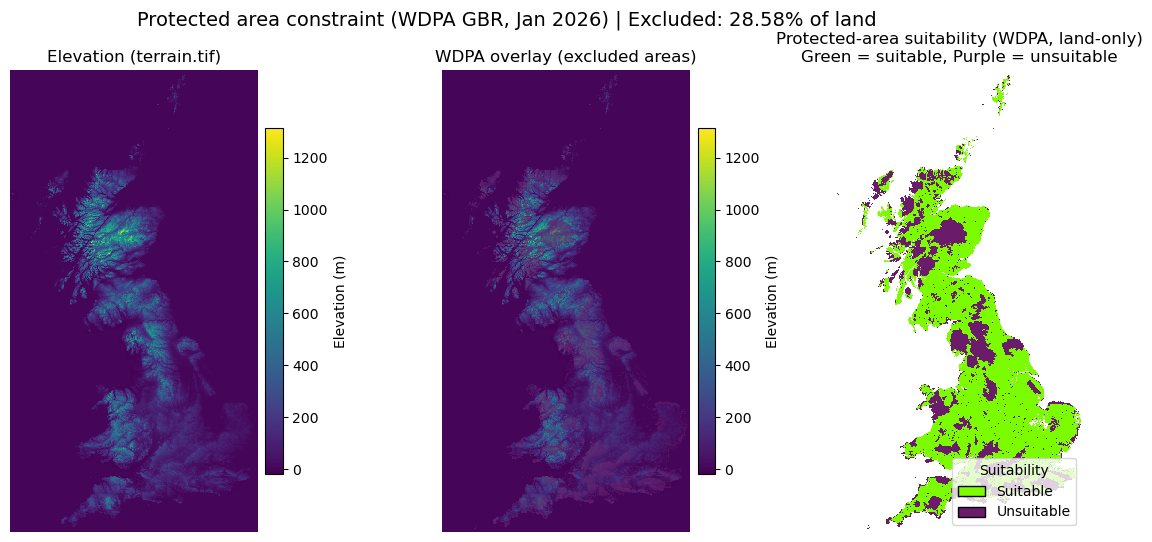

Saved figure: /Users/wangbobo/Desktop/WDPA_triplet_landonly.png
All outputs in: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs


In [2]:
import os
import glob
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from shapely.geometry import box


DEM_PATH = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/terrain.tif"

WDPA_DIRS = [
    "/Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_0",
    "/Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_1",
    "/Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_2",
]

OUT_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

os.environ["SHAPE_RESTORE_SHX"] = "YES"


with rasterio.open(DEM_PATH) as src:
    dem = src.read(1).astype("float32")
    dem_crs = src.crs
    dem_transform = src.transform
    dem_shape = dem.shape
    dem_bounds = src.bounds
    dem_nodata = src.nodata  

print("DEM CRS   :", dem_crs)
print("DEM shape :", dem_shape)
print("DEM nodata:", dem_nodata)


finite_mask = np.isfinite(dem)
if dem_nodata is not None:
    finite_mask = finite_mask & (dem != dem_nodata)


SEA_LEVEL = 0.0
land_mask = finite_mask & (dem > SEA_LEVEL)



dem_bbox_geom = box(dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top)


excluded = np.zeros(dem_shape, dtype="uint8")


for d in WDPA_DIRS:
    shp_list = sorted(glob.glob(os.path.join(d, "*.shp")))
    if not shp_list:
        raise FileNotFoundError(f"在 {d} 没找到 .shp 文件")
    shp = shp_list[0]
    print(f"\n[WDPA] Using shapefile: {shp}")

    tmp = gpd.read_file(shp, rows=1)
    wdpa_crs = tmp.crs
    del tmp
    if wdpa_crs is None:
        raise ValueError(f"{shp} 没有 CRS（可能缺 .prj）")

    bbox_gdf = gpd.GeoDataFrame(geometry=[dem_bbox_geom], crs=dem_crs)
    bbox_in_wdpa = bbox_gdf.to_crs(wdpa_crs).geometry.iloc[0]

    wdpa = gpd.read_file(shp, bbox=bbox_in_wdpa)
    print("  features after bbox filter:", len(wdpa))
    if len(wdpa) == 0:
        continue

    if wdpa.crs != dem_crs:
        wdpa = wdpa.to_crs(dem_crs)

    wdpa = wdpa[wdpa.geometry.notnull()].copy()
    wdpa["geometry"] = wdpa.geometry.buffer(0)
    wdpa = wdpa[~wdpa.geometry.is_empty].copy()

    shapes = ((geom, 1) for geom in wdpa.geometry)
    part = rasterize(
        shapes=shapes,
        out_shape=dem_shape,
        transform=dem_transform,
        fill=0,
        dtype="uint8",
        all_touched=False
    )

    excluded = np.maximum(excluded, part)

    del wdpa, part

print("\nDone rasterizing WDPA parts.")


suitability = (1 - excluded).astype("float32")


suitability_land = np.where(land_mask, suitability, np.nan)
excluded_land = np.where(land_mask, excluded, np.nan)

excluded_pct = 100.0 * np.nansum(excluded_land == 1) / np.nansum(land_mask)
print(f"Excluded % of LAND cells (WDPA) = {excluded_pct:.2f}%")


out_tif = os.path.join(OUT_DIR, "WDPA_suitability_land_0_1.tif")

NODATA_OUT = -9999.0
out_arr = np.where(np.isfinite(suitability_land), suitability_land, NODATA_OUT).astype("float32")

with rasterio.open(DEM_PATH) as src:
    profile = src.profile.copy()
profile.update(dtype="float32", count=1, nodata=NODATA_OUT)

with rasterio.open(out_tif, "w", **profile) as dst:
    dst.write(out_arr, 1)

print("Saved raster:", out_tif)


fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 3, wspace=0.15)

# --- (1) DEM
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(dem, interpolation="nearest")
ax1.set_title("Elevation (terrain.tif)")
ax1.set_axis_off()
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Elevation (m)")

# --- (2) DEM + WDPA overlay
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(dem, interpolation="nearest")
ax2.set_title("WDPA overlay (excluded areas)")
ax2.set_axis_off()
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label("Elevation (m)")

overlay_excl = np.where((excluded == 1) & land_mask, 1.0, np.nan)
ax2.imshow(
    overlay_excl,
    interpolation="nearest",
    alpha=0.55,
    cmap=ListedColormap(["#6A1B6A"])
)

# --- (3) Land-only Suitability
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Protected-area suitability (WDPA, land-only)\nGreen = suitable, Purple = unsuitable")
ax3.set_axis_off()
ax3.set_facecolor("white")  

cmap_suit = ListedColormap(["#6A1B6A", "#7CFC00"])  
cmap_suit.set_bad(alpha=0)  
norm_suit = BoundaryNorm([-0.5, 0.5, 1.5], cmap_suit.N)


suit_masked = np.ma.masked_where(~land_mask, suitability)

ax3.imshow(suit_masked, interpolation="nearest", cmap=cmap_suit, norm=norm_suit)

legend_handles = [
    Patch(facecolor="#7CFC00", edgecolor="black", label="Suitable"),
    Patch(facecolor="#6A1B6A", edgecolor="black", label="Unsuitable"),
]
ax3.legend(handles=legend_handles, loc="lower right", title="Suitability", frameon=True)

fig.suptitle(
    f"Protected area constraint (WDPA GBR, Jan 2026) | Excluded: {excluded_pct:.2f}% of land",
    fontsize=14
)

out_png = "/Users/wangbobo/Desktop/WDPA_triplet_landonly.png"

plt.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print("Saved figure:", out_png)
print("All outputs in:", OUT_DIR)
